In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gridworld_env import get_task1_gridworld, get_task2_gridworld, get_task3_gridworld
from utils import paint_gridworld

## A Look Around GridWorld

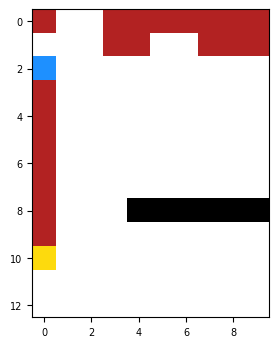

In [2]:
# initialize the grid world environment
env1 = get_task1_gridworld()

# This is how the environment looks like
paint_gridworld(env1, figsize=(4,4), ticksize=7)

## Example of running a simulation 

In [3]:
reward_lst = []

# Initialise the environment
# An arbitary gamma value is used here. You may need to change this!
env1 = get_task1_gridworld()

# Reset the environment to start from the starting location. 
# The reset() method returns the state, reward, and whether the episode is done or not
# More information can be found under the definition of the method
_, state, reward, done = env1.reset()
reward_lst.append(reward)

# While the trial is not done, i.e. the agent has not fallen into lava,
# the maximum length of the episode has not been exceeded, and the target has not been reached
while not done:
    
    # Take a step using the step() function and passing in one of the available actions [0, 1, 2, 3] 
    # corresponding to ['N', 'S', 'E', 'W']
    # More information can be found under the definition of the method
    # In this very simple example for each step we choose a random action
    _, state, reward, done = env1.step(np.random.choice(4))
    reward_lst.append(reward)

print(f'Collected rewards of an episode: {reward_lst}')

Collected rewards of an episode: [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -10.0]


Q Learning and SARSA Class definition

In [120]:
class QLearning():
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, softmax=False, stochastic_rewards=True):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.softmax = softmax
        self.stochastic_rewards = stochastic_rewards
        self.Q = np.zeros((env.get_state_size(), env.get_action_size()))
        self._goal_loc = [(0, 0)]
        self._lst_mean_std = [(0, 1)]
        self._R = np.zeros((env.get_state_size(), env.get_action_size()))

    def choose_action(self, state):
        if self.softmax:
            action_probs = self.softmax_policy(state)
            action = np.random.choice(self.env.get_action_size(), p=action_probs)
        else:
            if np.random.uniform(0, 1) < self.epsilon:
                action = np.random.choice(self.env.get_action_size())
            else:
                action = np.argmax(self.Q[state])
        return action

    def softmax_policy(self, state):
        """
        Compute the softmax policy for the given state.

        Args:
            state: The current state.

        Returns:
            The probabilities of each action under the softmax policy.
        """
        
        q_values = self.Q[state]
        exp_values = np.exp(np.clip(self.Q[state] / self.epsilon, -np.inf, 700))
        action_probs = exp_values / np.sum(exp_values)
        action_probs/=np.sum(action_probs)
        return action_probs
    
    

    def update_q_table(self, state, action, reward, next_state):
        target = reward + self.gamma * np.max(self.Q[next_state])
        td_error = target - self.Q[state, action]
        self.Q[state, action] += self.alpha * td_error

    def stochastic_reward(self):
        for goal_loc, (mean, std) in zip(self._goal_loc, self._lst_mean_std):
            goal_state = self.env._get_state_from_loc(goal_loc)
            reward = np.random.normal(mean, std)
            self._R[:, goal_state] = reward

    def train(self, num_episodes):
        episode_rewards = []
        episode_steps = []

        for episode in range(num_episodes):
            self.stochastic_reward()
            t, state, total_reward, done = self.env.reset()
            action = self.choose_action(state)
            episode_reward = 0
            episode_step = 0
            while not done:
                episode_step += 1
                next_t, next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                action = self.choose_action(next_state)
                episode_reward += reward
                t, state = next_t, next_state
            episode_rewards.append(episode_reward)
            episode_steps.append(episode_step)
            
            
            
        return episode_rewards, episode_steps
    
class SARSA():
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, softmax=False, stochastic_rewards=True):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.softmax = softmax
        self.stochastic_rewards = stochastic_rewards
        self.Q = np.zeros((env.get_state_size(), env.get_action_size()))
        self._goal_loc = [(0, 0)]
        self._lst_mean_std = [(0, 1)]
        self._R = np.zeros((env.get_state_size(), env.get_action_size()))

    def choose_action(self, state):
        if self.softmax:
            action_probs = self.softmax_policy(state)
            action = np.random.choice(self.env.get_action_size(), p=action_probs)
        else:
            if np.random.uniform(0, 1) < self.epsilon:
                action = np.random.choice(self.env.get_action_size())
            else:
                action = np.argmax(self.Q[state])
        return action

    def softmax_policy(self, state):
        """
        Compute the softmax policy for the given state.

        Args:
            state: The current state.

        Returns:
            The probabilities of each action under the softmax policy.
        """
        q_values = self.Q[state]
        exp_values = np.exp(np.clip(self.Q[state] / self.epsilon, -np.inf, 700))
        action_probs = exp_values / np.sum(exp_values)
        action_probs/=np.sum(action_probs)
        return action_probs

        
    def _get_state_from_loc(self, loc):
        return self._locations.index(tuple(loc))

    def update_q_table(self, state, action, reward, next_state, next_action):
        if self.softmax:
            target = reward + self.gamma * np.sum(self.Q[next_state] * self.softmax_policy(next_state))
        else:
            target = reward + self.gamma * np.max(self.Q[next_state])
        td_error = target - self.Q[state, action]
        self.Q[state, action] += self.alpha * td_error

    def stochastic_reward(self):
        for goal_loc, (mean, std) in zip(self._goal_loc, self._lst_mean_std):
            goal_state = self.env._get_state_from_loc(goal_loc)
            reward = np.random.normal(mean, std)
            self._R[:, goal_state] = reward

    def train(self, num_episodes):
        episode_rewards = []
        episode_steps = []

        for episode in range(num_episodes):
            self.stochastic_reward()
            t, state, total_reward, done = self.env.reset()
            action = self.choose_action(state)
            episode_reward = 0
            episode_step = 0
            while not done:
                episode_step += 1
                next_t, next_state, reward, done = self.env.step(action)
                next_action = self.choose_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)
                episode_reward += reward
                t, state, action = next_t, next_state, next_action
            episode_rewards.append(episode_reward)
            episode_steps.append(episode_step)
          
                     
        return episode_rewards, episode_steps


# Single Target, Deterministic Rewards:

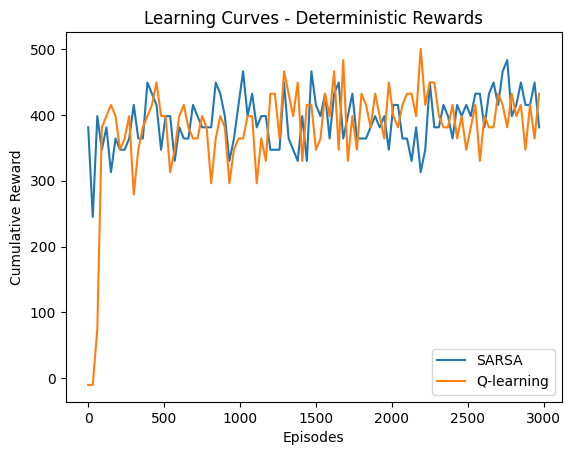

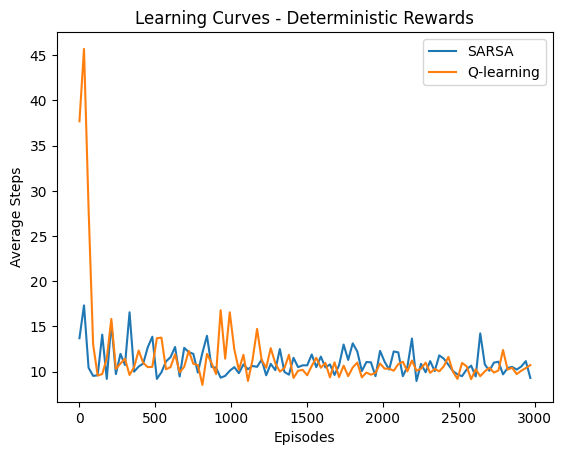

In [124]:
# Initialize environment 

env=get_task1_gridworld()

# Initilaize SARSA and Q Agents
agent_sarsa = SARSA(env, softmax=False,stochastic_rewards=False)

agent_q_learning = QLearning(env, softmax=False,stochastic_rewards=False)

# Training
num_episodes = 3000
sarsa_rewards, sarsa_steps = agent_sarsa.train(num_episodes)
q_learning_rewards, q_learning_steps = agent_q_learning.train(num_episodes)

# Group rewards and steps into intervals of episodes
def group_data(data):
    grouped_data = [np.mean(data[i:i+30]) for i in range(0, len(data), 30)]
    return grouped_data

sarsa_rewards_grouped = group_data(sarsa_rewards)
q_learning_rewards_grouped = group_data(q_learning_rewards)

sarsa_steps_grouped = group_data(sarsa_steps)
q_learning_steps_grouped = group_data(q_learning_steps)

# Plot learning curves
plt.plot(np.arange(1, num_episodes + 1, 30), sarsa_rewards_grouped, label='SARSA')
plt.plot(np.arange(1, num_episodes + 1, 30), q_learning_rewards_grouped, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curves - Deterministic Rewards')
plt.legend()
plt.show()

plt.plot(np.arange(1, num_episodes + 1, 30), sarsa_steps_grouped, label='SARSA')
plt.plot(np.arange(1, num_episodes + 1, 30), q_learning_steps_grouped, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Average Steps')
plt.title('Learning Curves - Deterministic Rewards')
plt.legend()
plt.show()


Checking the effect of different hyperparameters

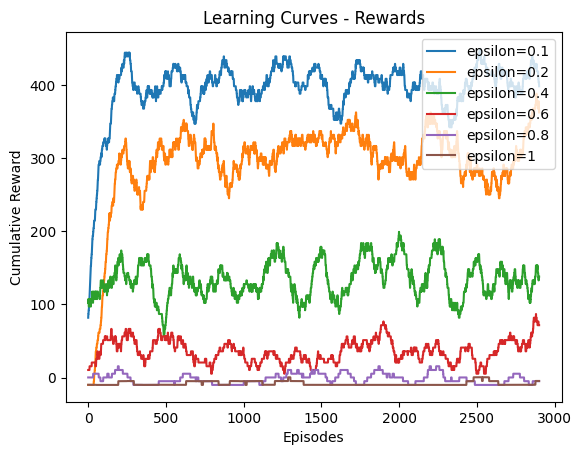

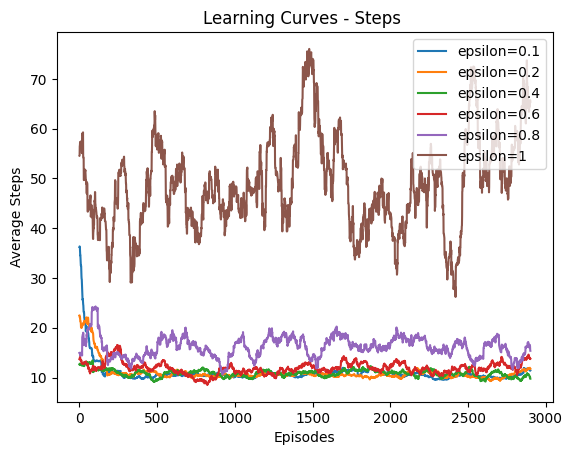

In [7]:
epsilon_values = [0.1, 0.2, 0.4,0.6,0.8,1]
rewards_dict = {}
steps_dict = {}

def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size
for epsilon in epsilon_values:
    
    agent_q_learning = QLearning(env, epsilon=epsilon)
    q_learning_rewards, q_learning_steps = agent_q_learning.train(num_episodes)
    rewards_dict[epsilon] = moving_average(q_learning_rewards)
    steps_dict[epsilon] = moving_average(q_learning_steps)

# Plot learning curves for rewards
for epsilon, rewards in rewards_dict.items():
    plt.plot(np.arange(1, len(rewards) + 1), rewards, label=f'epsilon={epsilon}')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curves - Rewards')
plt.legend(loc='upper right')
plt.show()

for epsilon, steps in steps_dict.items():
    plt.plot(np.arange(1, len(steps) + 1), steps, label=f'epsilon={epsilon}')
plt.xlabel('Episodes')
plt.ylabel('Average Steps')
plt.title('Learning Curves - Steps ')
plt.legend(loc='upper right')
plt.show()

Plot the Preferred Movements

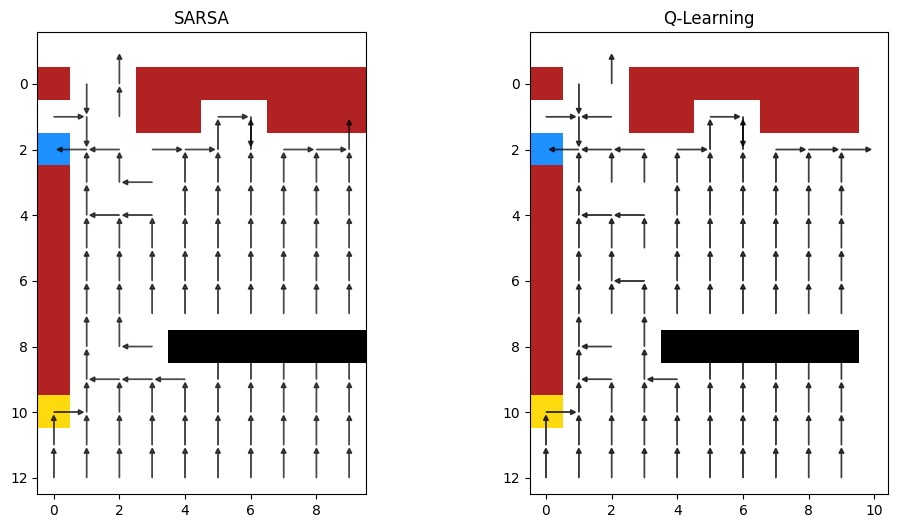

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from gridworld_env import GridWorld, get_task1_gridworld
from utils import get_grid

# Initialize environment
env = get_task1_gridworld()

# Initialize SARSA Agent
agent_sarsa = SARSA(env)
# Initialize Q-learning Agent
agent_q_learning = QLearning(env)

# Training for one episode for SARSA
num_episodes = 5000
sarsa_rewards, sarsa_steps = agent_sarsa.train(num_episodes)

# Training for one episode for Q-learning
q_learning_rewards, q_learning_steps = agent_q_learning.train(num_episodes)

# Get the preferred action at each state for SARSA
preferred_actions_sarsa = np.argmax(agent_sarsa.Q, axis=1)

# Get the preferred action at each state for Q-learning
preferred_actions_q_learning = np.argmax(agent_q_learning.Q, axis=1)

# Get the grid layout from utils.py
grid = get_grid(env)

# Get the starting location
start_loc = env.get_starting_loc()

# Get the target location directly from the environment's attribute
target_loc = env.get_goal_loc()[0]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# SARSA plot
axs[0].imshow(grid, cmap='gray')
axs[0].set_title('SARSA')
axs[0].plot(start_loc[1], start_loc[0])
for wall_loc in env.get_walls_loc():
    axs[0].plot(wall_loc[1], wall_loc[0])
for lava in env.get_lava_loc():
    axs[0].plot(lava[1], lava[0])
for state, action in enumerate(preferred_actions_sarsa):
    loc = env.get_loc_from_state(state)
    if env.is_terminal(state) or loc in env.get_walls_loc() or loc in env.get_lava_loc():
        continue
    arrow_color = 'k' # Black color for all arrows
    arrow_directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]  # Directions: up, right, down, left
    dx, dy = arrow_directions[action]
    axs[0].arrow(loc[1], loc[0], dx * 0.75, dy * 0.75, color=arrow_color, alpha=0.7, head_width=0.15, head_length=0.15)

# Q-learning plot
axs[1].imshow(grid, cmap='gray')
axs[1].set_title('Q-Learning')
axs[1].plot(start_loc[1], start_loc[0])
for wall_loc in env.get_walls_loc():
    axs[1].plot(wall_loc[1], wall_loc[0])
for lava in env.get_lava_loc():
    axs[1].plot(lava[1], lava[0])
for state, action in enumerate(preferred_actions_q_learning):
    loc = env.get_loc_from_state(state)
    if env.is_terminal(state) or loc in env.get_walls_loc() or loc in env.get_lava_loc():
        continue
    arrow_color = 'k' # Black color for all arrows
    arrow_directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]  # Directions: up, right, down, left
    dx, dy = arrow_directions[action]
    axs[1].arrow(loc[1], loc[0], dx * 0.75, dy * 0.75, color=arrow_color, alpha=0.75, head_width=0.15, head_length=0.15)

plt.show()


Changing policy to “Softmax”

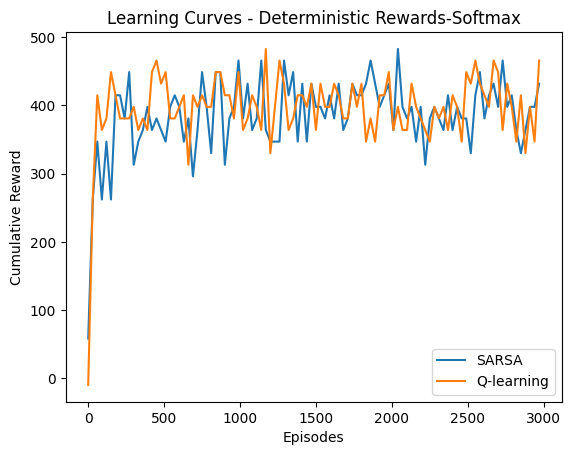

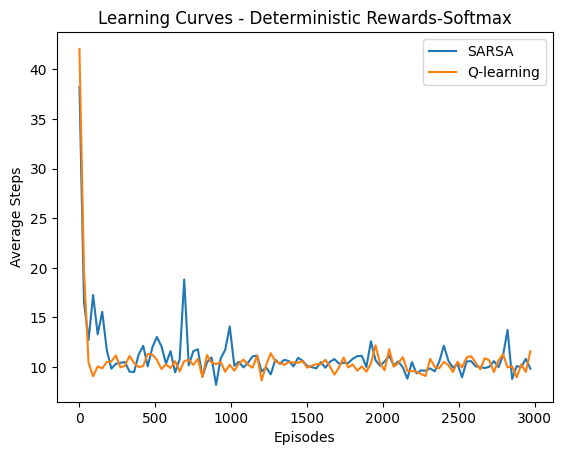

In [119]:
# Initialize environment 

env=get_task1_gridworld()

# Initilaize SARSA and Q Agents
agent_sarsa = SARSA(env, softmax=True,stochastic_rewards=False)

agent_q_learning = QLearning(env, softmax=True,stochastic_rewards=False)

# Training
num_episodes = 3000
sarsa_rewards, sarsa_steps = agent_sarsa.train(num_episodes)
q_learning_rewards, q_learning_steps = agent_q_learning.train(num_episodes)

# Group rewards and steps into intervals of episodes
def group_data(data):
    grouped_data = [np.mean(data[i:i+30]) for i in range(0, len(data), 30)]
    return grouped_data

sarsa_rewards_grouped = group_data(sarsa_rewards)
q_learning_rewards_grouped = group_data(q_learning_rewards)

sarsa_steps_grouped = group_data(sarsa_steps)
q_learning_steps_grouped = group_data(q_learning_steps)

# Plot learning curves
plt.plot(np.arange(1, num_episodes + 1, 30), sarsa_rewards_grouped, label='SARSA')
plt.plot(np.arange(1, num_episodes + 1, 30), q_learning_rewards_grouped, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curves - Deterministic Rewards-Softmax')
plt.legend()
plt.show()

plt.plot(np.arange(1, num_episodes + 1, 30), sarsa_steps_grouped, label='SARSA')
plt.plot(np.arange(1, num_episodes + 1, 30), q_learning_steps_grouped, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Average Steps')
plt.title('Learning Curves - Deterministic Rewards-Softmax')
plt.legend()
plt.show()


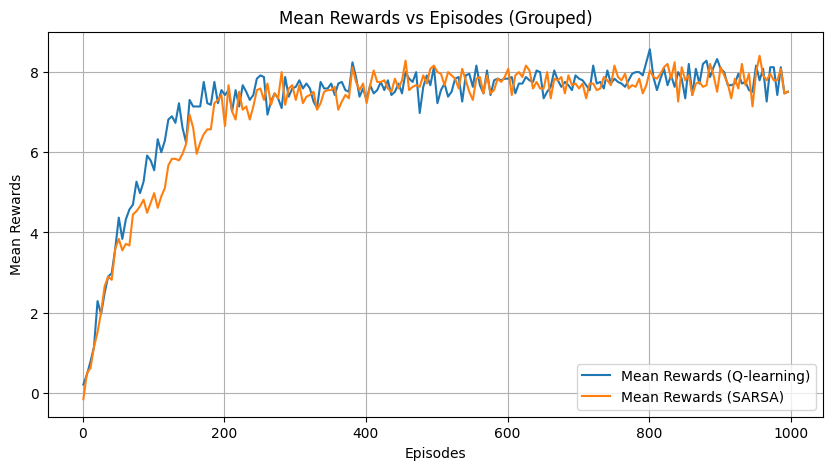

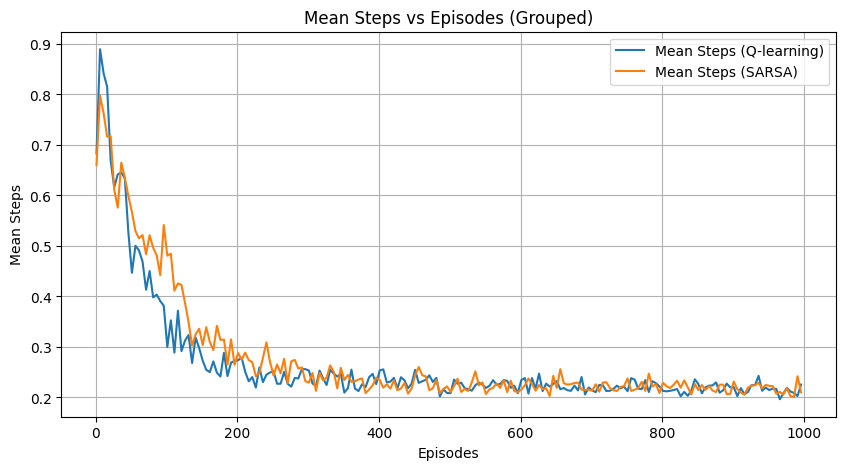

In [95]:
# Initialize lists to store results across runs
total_rewards_list_q = []
total_steps_list_q = []
total_rewards_list_sarsa = []
total_steps_list_sarsa = []

env=get_task1_gridworld()

num_runs = 50
n_episodes = 1000  # increase to 3000

for n in range(num_runs):
    # Train Q-learning
    q_agent = QLearning(env,softmax=False,stochastic_rewards=False)
    q_rewards, q_steps = q_agent.train(n_episodes)
    total_rewards_list_q.append(q_rewards)
    total_steps_list_q.append(q_steps)
    
    # Train SARSA
    sarsa_agent = SARSA(env,softmax=False,stochastic_rewards=False)
    sarsa_rewards, sarsa_steps = sarsa_agent.train(n_episodes)
    total_rewards_list_sarsa.append(sarsa_rewards)
    total_steps_list_sarsa.append(sarsa_steps)

# Calculate mean across runs for Q-learning
mean_rewards_q = np.mean(total_rewards_list_q, axis=0)/50
mean_steps_q = np.mean(total_steps_list_q, axis=0)/50

# Calculate mean across runs for SARSA
mean_rewards_sarsa = np.mean(total_rewards_list_sarsa, axis=0)/50
mean_steps_sarsa = np.mean(total_steps_list_sarsa, axis=0)/50

# Plot rewards versus episodes for both agents
plt.figure(figsize=(10, 5))
group_size = 5
mean_rewards_q_grouped = np.mean(mean_rewards_q.reshape(-1, group_size), axis=1)
mean_rewards_sarsa_grouped = np.mean(mean_rewards_sarsa.reshape(-1, group_size), axis=1)
plt.plot(np.arange(1, n_episodes + 1, group_size), mean_rewards_q_grouped, label='Mean Rewards (Q-learning)')
plt.plot(np.arange(1, n_episodes + 1, group_size), mean_rewards_sarsa_grouped, label='Mean Rewards (SARSA)')
plt.title('Mean Rewards vs Episodes (Grouped)')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.legend()
plt.grid(True)
plt.show()

# Plot steps versus episodes for both agents
plt.figure(figsize=(10, 5))
mean_steps_q_grouped = np.mean(mean_steps_q.reshape(-1, group_size), axis=1)
mean_steps_sarsa_grouped = np.mean(mean_steps_sarsa.reshape(-1, group_size), axis=1)
plt.plot(np.arange(1, n_episodes + 1, group_size), mean_steps_q_grouped, label='Mean Steps (Q-learning)')
plt.plot(np.arange(1, n_episodes + 1, group_size), mean_steps_sarsa_grouped, label='Mean Steps (SARSA)')
plt.title('Mean Steps vs Episodes (Grouped)')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.legend()
plt.grid(True)
plt.show()


# Dual Targets, Stochastic Rewards

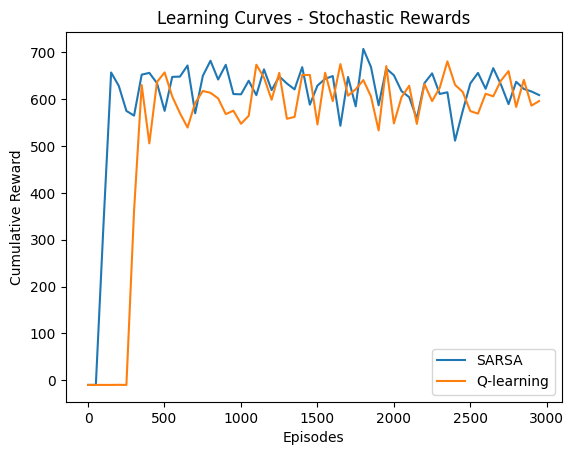

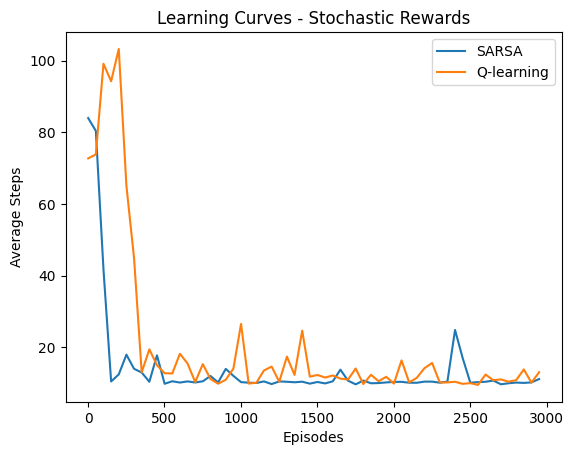

In [88]:
# Initialize environment and agents

env=get_task2_gridworld()

# stochastic_rewards=True for using stochastic rewards
agent_sarsa = SARSA(env,epsilon=0.05,softmax=False,stochastic_rewards=True)
agent_q_learning = QLearning(env,epsilon=0.05,softmax=False,stochastic_rewards=True)

# Training
num_episodes = 3000
sarsa_rewards, sarsa_steps = agent_sarsa.train(num_episodes)
q_learning_rewards, q_learning_steps = agent_q_learning.train(num_episodes)

# Group rewards and steps into intervals of episodes
def group_data(data):
    grouped_data = [np.mean(data[i:i+50]) for i in range(0, len(data), 50)]
    return grouped_data

sarsa_rewards_grouped = group_data(sarsa_rewards)
q_learning_rewards_grouped = group_data(q_learning_rewards)

sarsa_steps_grouped = group_data(sarsa_steps)
q_learning_steps_grouped = group_data(q_learning_steps)

# Plot learning curves
plt.plot(np.arange(1, num_episodes + 1, 50), sarsa_rewards_grouped, label='SARSA')
plt.plot(np.arange(1, num_episodes + 1, 50), q_learning_rewards_grouped, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curves - Stochastic Rewards')
plt.legend()
plt.show()

plt.plot(np.arange(1, num_episodes + 1, 50), sarsa_steps_grouped, label='SARSA')
plt.plot(np.arange(1, num_episodes + 1, 50), q_learning_steps_grouped, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Average Steps')
plt.title('Learning Curves - Stochastic Rewards')
plt.legend()
plt.show()

# Stochastic Transitions and Rewards

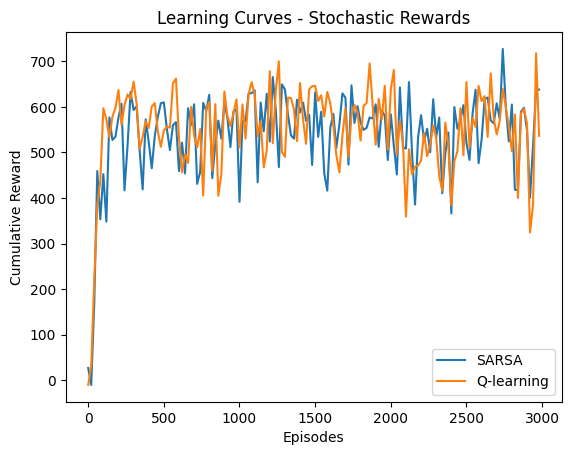

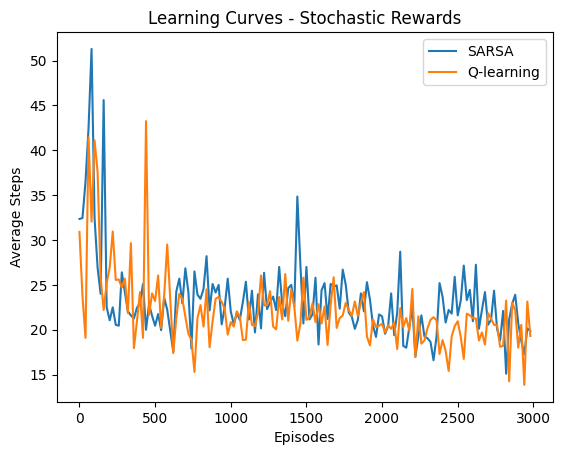

In [94]:
# Initialize environment and agents

env=get_task3_gridworld()

# stochastic_rewards=True for using stochastic rewards
agent_sarsa = SARSA(env,epsilon=0.05,softmax=False,stochastic_rewards=True)
agent_q_learning = QLearning(env,epsilon=0.05,softmax=False,stochastic_rewards=True)

# Training
num_episodes = 3000
sarsa_rewards, sarsa_steps = agent_sarsa.train(num_episodes)
q_learning_rewards, q_learning_steps = agent_q_learning.train(num_episodes)

# Group rewards and steps into intervals of episodes
def group_data(data):
    grouped_data = [np.mean(data[i:i+20]) for i in range(0, len(data), 20)]
    return grouped_data

sarsa_rewards_grouped = group_data(sarsa_rewards)
q_learning_rewards_grouped = group_data(q_learning_rewards)

sarsa_steps_grouped = group_data(sarsa_steps)
q_learning_steps_grouped = group_data(q_learning_steps)

# Plot learning curves
plt.plot(np.arange(1, num_episodes + 1, 20), sarsa_rewards_grouped, label='SARSA')
plt.plot(np.arange(1, num_episodes + 1, 20), q_learning_rewards_grouped, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curves - Stochastic Rewards')
plt.legend()
plt.show()

plt.plot(np.arange(1, num_episodes + 1, 20), sarsa_steps_grouped, label='SARSA')
plt.plot(np.arange(1, num_episodes + 1, 20), q_learning_steps_grouped, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Average Steps')
plt.title('Learning Curves - Stochastic Rewards')
plt.legend()
plt.show()